# Options 3: The Black-Scholes Model

This notebook introduces the Black-Scholes option pricing model. It also discusses *(a)* implied volatility; *(b)* how to calculate the Black-Scholes model by numerical integration and *(c)* how the binomial model converges to the Black-Scholes model.

## Load Packages and Extra Functions

In [1]:
using Printf, Distributions, Roots, QuadGK

include("jlFiles/printmat.jl");

In [2]:
using Plots

gr(size=(480,320))
default(fmt = :png)

# Black-Scholes

The Black-Scholes formula for a European call option on an asset with a continuous dividend rate $\delta$ is

$C  =e^{-\delta m}S\Phi(d_{1}) - e^{-ym}K\Phi(d_{2})$, where

$d_{1} =\frac{\ln(S/K)+(y-\delta+\sigma^{2}/2)m}{\sigma\sqrt{m}} \ \text{ and } \ d_{2}=d_{1}-\sigma\sqrt{m}$ 

and where $\Phi(d)$ denotes the probability of $x\leq d$ when $x$ has an $N(0,1)$ distribution. In other words, $\Phi(d)$ is the cumulative distribution function of the $N(0,1)$ distribution.

### A Remark on the Code

- `Φ(x)= cdf(Normal(0,1),x)` is a one-line definition of a function.

- The `;isPut=false` creates a keyword argument which defaults to `false` which means that we calculate a call option price. To calculate a put option price, use the function as `OptionBlackSPs(...;isPut=true)`.

In [3]:
"""
    Φ(x)
Calculate Pr(z<=x) for N(0,1) variable z. Convenient short hand notation. Used in `OptionBlackSPs()`.
"""
Φ(x)= cdf(Normal(0,1),x)


"""
Calculate Black-Scholes European call or put option price, continuous dividends of δ
"""
function OptionBlackSPs(S,K,m,y,σ,δ=0;isPut=false)
    d1 = ( log(S/K) + (y-δ+0.5*σ^2)*m ) / (σ*sqrt(m))
    d2 = d1 - σ*sqrt(m)
    c  = exp(-δ*m)*S*Φ(d1) - K*exp(-y*m)*Φ(d2)
    price = isPut ? c - exp(-δ*m)*S + exp(-y*m)*K : c
    return price
end

OptionBlackSPs

In [4]:
(S,K,m,y,σ) = (42,42,0.5,0.05,0.2)           #some parameter values  

C = OptionBlackSPs(S,K,m,y,σ)                #call
P = OptionBlackSPs(S,K,m,y,σ,0;isPut=true)   #put

δ = 0.03
Cδ = OptionBlackSPs(S,K,m,y,σ,δ)             #call, with dividends
Pδ = OptionBlackSPs(S,K,m,y,σ,δ;isPut=true)  #put

printblue("Option prices at S=$S and K=$K: ")
xx = [P Pδ;C Cδ]
printmat(xx;rowNames=["put","call"],colNames=["no dividends","δ=$δ"],width=15,colUnderlineQ=true)

Option prices at S=42 and K=42: 
       no dividends         δ=0.03
       ¯¯¯¯¯¯¯¯¯¯¯¯         ¯¯¯¯¯¯
put           1.856          2.121
call          2.893          2.532



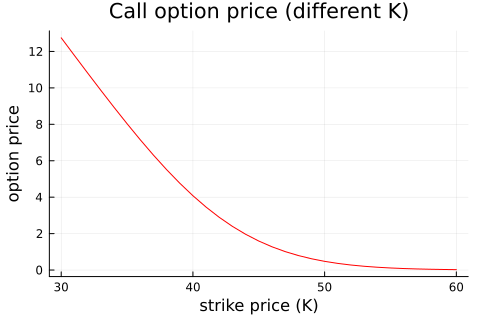

In [5]:
K_range = 30:60           #different strike prices
C_K     = OptionBlackSPs.(S,K_range,m,y,σ)

p1 = plot( K_range,C_K,
           linecolor = :red,
           legend = false,
           title  = "Call option price (different K)",
           xlabel = "strike price (K)",
           ylabel = "option price" )
display(p1)

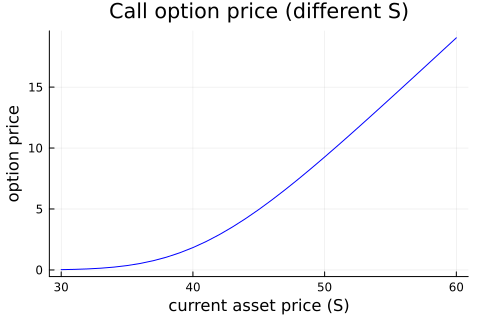

In [6]:
S_range = 30:60                            #different spot prices
C_S     = OptionBlackSPs.(S_range,K,m,y,σ)

p1 = plot( S_range,C_S,
           linecolor = :blue,
           legend = false,
           title  = "Call option price (different S)",
           xlabel = "current asset price (S)",
           ylabel = "option price" )
display(p1)

# How the Black-Scholes Depends on Volatility

The Black-Scholes option price is an increasing function of the volatility ($\sigma$), as illustrated below.

# Implied Volatility

In the cell below we use an observed option price and solve the BS formula for $\sigma$. This is the "implied volatility". We do this for several option prices: the Black-Scholes price and also higher and lower prices.


### A Remark on the Code

- To solve for the implied volatility, the next cells use the [Roots.jl](https://github.com/JuliaMath/Roots.jl) package. 
- We solve for the root of the anonymous function `σ->OptionBlackSPs(S,K,m,y,σ)-C` which finds `σ` so that the model based price from `OptionBlackSPs()` minus the actual price `C` equals 0. We loop over a few different values of `C`.
- `iv = [... for Cᵢ in C_range]` creates a vector with one element per element in `C_range`.

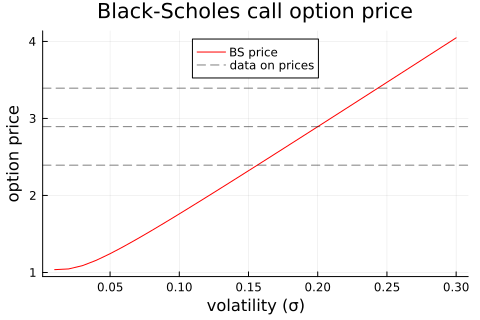

In [7]:
σ_range = 0.01:0.01:0.3           #S,K,m,y are scalars, σ_range is a vector
C_σ     = OptionBlackSPs.(S,K,m,y,σ_range)    #at different σ values

p1 = plot( σ_range,C_σ,
           linecolor = :red,
           label = "BS price",
           title = "Black-Scholes call option price",
           xlabel = "volatility (σ)",
           ylabel = "option price",
           legend = :top )
hline!( [C,C+0.5,C-0.5],linetype=:hline,linecolor=:black,line=(:dash,0.5),label="data on prices")
display(p1)

In [8]:
C_range = [C,C-0.5,C+0.05]     #B-S price, cheaper, more expensive

iv = [find_zero(σ->OptionBlackSPs(S,K,m,y,σ)-Cᵢ,(0,5)) for Cᵢ in C_range]

printblue("implied volatility:")
printmat(iv;rowNames=["Benchmark","Cheap option","Expensive option"])

printred("Compare the results with the previous graph\n")

implied volatility:
Benchmark            0.200
Cheap option         0.156
Expensive option     0.204

Compare the results with the previous graph



# BS from an Explicit Integration

The price of a European a call option is 

$
C=e^{-ym}\text{E}^{\ast}\max(0,S_{m}-K),
$

which can be written

$
C=e^{-ym}\int_{0}^{\infty}\max(0,S_{m}-K)  f^{\ast}(S_{m})dS_{m},
$

where $f^{\ast}(S_{m})$ is the risk neutral density function of the asset
price at expiration ($S_{m}$). The integration starts at $S_m=0$ since the spot price cannot go below zero, but we could equally well integrate from $K$ instead (since $\max(0,S_{m}-K)$ is 0 for $S_m<K$.) See the figure below.

In the Black-Scholes model, the risk neutral distribution of $\ln S_{m}$ is

$
\ln S_{m}\sim^{\ast}\text{N}(\ln S+my-m \sigma^{2}/2,m \sigma^2),
$

where $S$ is the current asset price. This means that $f^{\ast}(S_m)$ is the pdf of a lognormally distributed variable with "mean" $\ln S+ym-\sigma^{2}m/2$ and "standard deviation" $\sigma \sqrt{m}$. Notice that this is the pdf of $S_m$, not its logarithm.

### A Remark on the Code

- The `LogNormal` in the `Distributions.jl` package wants the mean and standard deviation of $\log S_m$ as inputs, but calculates the pdf of $S_m$.
- The numerical integration is done by the [QuadGK.jl](https://github.com/JuliaMath/QuadGK.jl) package.
- The integration is of the anonymous function `x->BSintegrand(x,S,K,y,m,σ)` over the interval `[0,Inf]`. (`[K,Inf]` would give the same result.)  Here, `x` represents possible values of the underlying asset at expiration.

In [9]:
"""
BSintegrand(Sₘ,S,K,y,m,σ)

Constructs the integrand for the Black-Scholes call price
"""

function BSintegrand(Sₘ,S,K,y,m,σ)
    μ = log(S) + m*y - m*σ^2/2            #"mean"
    λ = sqrt(m)*σ                         #"std"
    f = pdf(LogNormal(μ,λ),Sₘ)            #log-normal pdf(mean,std) 
    z = exp(-y*m)*max(0,Sₘ-K)*f
    return z
end

BSintegrand (generic function with 1 method)

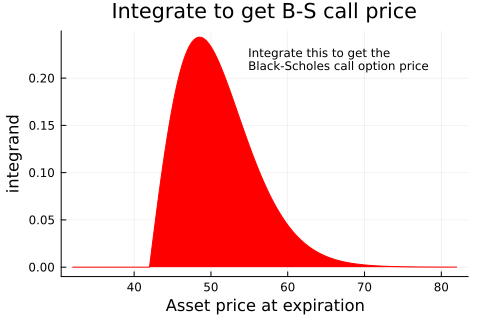

In [10]:
Sₘ_range = (K-10):0.25:(K+40)      #possible outcomes of underlying price

txt = text("Integrate this to get the\nBlack-Scholes call option price",8,:left)

p1 = plot( Sₘ_range,BSintegrand.(Sₘ_range,S,K,y,m,σ),
           linecolor = :red,
           ylim = (-0.01,0.25),
           fill = (0,:red),
           legend = false,
           title = "Integrate to get B-S call price",
           xlabel = "Asset price at expiration",
           ylabel = "integrand",
           annotation = (55,0.22,txt) )
display(p1)

In [11]:
C1, = QuadGK.quadgk(x->BSintegrand(x,S,K,y,m,σ),0,Inf)    #numerical integration over (0,Inf)
#QuadGK.quadgk(x->BSintegrand(x,S,K,y,m,σ),K,Inf)         #gives the same result

printblue("Call option price:")
printmat([C1,C],rowNames=["from numerical integration","from BS formula"])

Call option price:
from numerical integration     2.893
from BS formula                2.893



# Convergence of BOPM to BS

The next few cells calculate the option price according to binomial model with a CRR calibration where

$
u=e^{\sigma\sqrt{h}}, d=e^{-\sigma\sqrt{h}} \text{ and } p=\frac{e^{yh}-d}{u-d}.
$

This is done repeatedly, using more and more time steps ($n$) with $h=m/n$ where $m$ is the fixed time to expiration.

The file included below contains, among other things, the functions `BuildSTree()` and `EuOptionPrice()` from the chapter on the binomial model.6

In [12]:
using OffsetArrays
include("jlFiles/OptionsCalculations.jl");

In [13]:
#(S,K,m,y,σ) = (42,42,0.5,0.05,0.2)       #these parameters were defined before

nMax = 200

C_bopm = fill(NaN,nMax)
for n = 1:nMax                         #calculate option price nMax times 
    #local h, u, d, p, STree, Ce       #local/global is needed in script
    h = m/n                 #time step size (in years)
    u = exp(σ*sqrt(h))
    d = exp(-σ*sqrt(h))
    p = (exp(y*h) - d)/(u-d)
    STree     = BuildSTree(S,n,u,d)
    Ce        = EuOptionPrice(STree,K,y,h,p)
    C_bopm[n] = Ce[0][]        #pick out the call price at the starting node
end

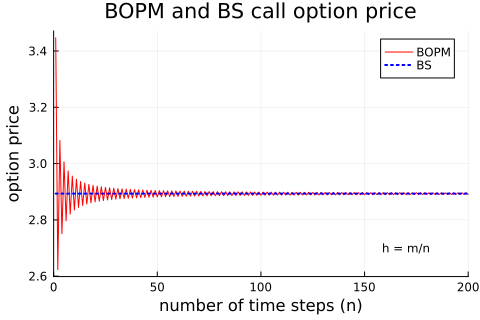

In [14]:
p1 = plot( 1:nMax,[C_bopm fill(C,nMax)],
           linecolor = [:red :blue],
           linestyle = [:solid :dot],
           linewidth = [1 2],
           xlims = [0,nMax],
           label = ["BOPM" "BS"],
           title = "BOPM and BS call option price",
           xlabel = "number of time steps (n)",
           ylabel = "option price",
           annotation = (170,2.7,text("h = m/n",8)) )
display(p1)